





<a name="top"> <h1>02- Spatial Analisis Part 2</h1> <a>

<p>Geospatial Analysis of the 2023 Earthquakes in Turkey<br />
<strong>Master Thesis</strong><br />
<strong>Master of Data Science</strong></p>


<p style="text-align:right">Gozde Yazganoglu (<em>gozde.yazganoglu@cunef.edu</em>)</p>

In [22]:
!conda info


     active environment : new_geo_env
    active env location : /home/lapita/anaconda3/envs/new_geo_env
            shell level : 2
       user config file : /home/lapita/.condarc
 populated config files : /home/lapita/.condarc
          conda version : 22.9.0
    conda-build version : 3.22.0
         python version : 3.9.12.final.0
       virtual packages : __cuda=12.0=0
                          __linux=6.2.0=0
                          __glibc=2.35=0
                          __unix=0=0
                          __archspec=1=x86_64
       base environment : /home/lapita/anaconda3  (writable)
      conda av data dir : /home/lapita/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https:/

In [23]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
from aux_func import save_data


In [24]:
#reading the data 
# 
data = gpd.read_file('../data/processed/dataset2.geojson')

data.head()

,obj_type,info,damage_gra,locality,population,income,total_sales,second_sales,water_access,elec_cons,...,fertility,hh_size,longitude,latitude,nearest_water_source_distance,nearest_camping_distance,nearest_earthquake_distance,nearest_fault_distance,elev,geometry
0,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.0,38.314252,37.768867,0.077874,0.020232,0.097845,0.016935,660.0,POINT (38.31425 37.76887)
1,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.0,38.313284,37.768690,0.076904,0.019284,0.097004,0.017440,660.0,POINT (38.31328 37.76869)
2,12-Non-residential Buildings,1251-Industrial buildings,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.0,38.318013,37.768612,0.081336,0.023588,0.100527,0.014585,660.0,POINT (38.31801 37.76861)
3,12-Non-residential Buildings,1251-Industrial buildings,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.0,38.318677,37.768575,0.081953,0.024196,0.101013,0.014241,660.0,POINT (38.31868 37.76857)
4,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,2.36,4.0,38.312542,37.768514,0.076146,0.018542,0.096334,0.017826,660.0,POINT (38.31254 37.76851)


In [25]:

# Count the number of buildings with each damage grade in each locality
damage_counts = data.groupby(['locality', 'damage_gra']).size().reset_index(name='count')

# Count the total number of buildings in each locality
total_counts = data.groupby('locality').size().reset_index(name='total_count')

# Merge damage counts with total counts
merged = pd.merge(damage_counts, total_counts, on='locality')

# Calculate the percentage
merged['percentage'] = (merged['count'] / merged['total_count']) * 100

# This DataFrame now contains the percentage of each damage grade for each locality
print(merged)

# Optionally, if you want to merge these percentages back to your original dataset:
data = data.merge(merged[['locality', 'damage_gra', 'percentage', ]], on=['locality', 'damage_gra'], how='left')
merged.head()

     locality  damage_gra  count  total_count  percentage
0    ADIYAMAN           1   6531         6772   96.441229
1    ADIYAMAN           2     46         6772    0.679268
2    ADIYAMAN           3    143         6772    2.111636
3    ADIYAMAN           4     52         6772    0.767868
4       Afsin           1    655          712   91.994382
..        ...         ...    ...          ...         ...
71  Sanliurfa           3      2        11980    0.016694
72   Turkoglu           1    433          485   89.278351
73   Turkoglu           2     18          485    3.711340
74   Turkoglu           3     25          485    5.154639
75   Turkoglu           4      9          485    1.855670

[76 rows x 5 columns]


,locality,damage_gra,count,total_count,percentage
0,ADIYAMAN,1,6531,6772,96.441229
1,ADIYAMAN,2,46,6772,0.679268
2,ADIYAMAN,3,143,6772,2.111636
3,ADIYAMAN,4,52,6772,0.767868
4,Afsin,1,655,712,91.994382


In [26]:



# Filter buildings that are destroyed
destroyed = data[data['damage_gra'] == 4]

# Count the number of destroyed buildings per locality
destroyed_counts = destroyed.groupby('locality').size().reset_index(name='destroyed_count')

# Count the total number of buildings in each locality
total_counts = data.groupby('locality').size().reset_index(name='total_count')

# Merge counts
merged = pd.merge(total_counts, destroyed_counts, on='locality', how='left').fillna(0)

# Calculate the percentage
merged['destroyed_percentage'] = (merged['destroyed_count'] / merged['total_count']) * 100


In [27]:
# Filter buildings with damage_gra of 2, 3, or 4
damaged = data[data['damage_gra'].isin([2, 3, 4])]

# Count the number of these buildings per locality
damaged_counts = damaged.groupby('locality').size().reset_index(name='damaged_count')

# Merge this count with total_counts to get the percentage
percentage_df = pd.merge(total_counts, damaged_counts, on='locality', how='left').fillna(0)

# Calculate the percentage
percentage_df['damaged_percentage'] = (percentage_df['damaged_count'] / percentage_df['total_count']) * 100

# Merge the damaged_percentage back to the original dataframe
data = data.merge(percentage_df[['locality', 'damaged_percentage']], on='locality', how='left')


In [28]:


# Merge the destroyed_percentage back to the original dataframe
data = data.merge(merged[['locality', 'destroyed_percentage']], on='locality', how='left')


data.dropna(inplace=True)

In [29]:
import rasterio
data.to_crs(epsg=3857)

,obj_type,info,damage_gra,locality,population,income,total_sales,second_sales,water_access,elec_cons,...,latitude,nearest_water_source_distance,nearest_camping_distance,nearest_earthquake_distance,nearest_fault_distance,elev,geometry,percentage,damaged_percentage,destroyed_percentage
0,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,37.768867,0.077874,0.020232,0.097845,0.016935,660.0,POINT (4265123.057 4546825.706),96.441229,3.558771,0.767868
1,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,37.768690,0.076904,0.019284,0.097004,0.017440,660.0,POINT (4265015.307 4546800.748),96.441229,3.558771,0.767868
2,12-Non-residential Buildings,1251-Industrial buildings,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,37.768612,0.081336,0.023588,0.100527,0.014585,660.0,POINT (4265541.688 4546789.766),96.441229,3.558771,0.767868
3,12-Non-residential Buildings,1251-Industrial buildings,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,37.768575,0.081953,0.024196,0.101013,0.014241,660.0,POINT (4265615.640 4546784.574),96.441229,3.558771,0.767868
4,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,37.768514,0.076146,0.018542,0.096334,0.017826,660.0,POINT (4264932.654 4546776.009),96.441229,3.558771,0.767868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98789,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,37.371851,0.194512,0.012611,0.000852,0.031609,500.0,POINT (4103009.918 4491065.528),89.278351,10.721649,1.855670
98790,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,37.371509,0.194789,0.013011,0.000538,0.031945,500.0,POINT (4103033.200 4491017.634),89.278351,10.721649,1.855670
98791,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,37.371981,0.194226,0.012857,0.001146,0.031466,500.0,POINT (4103079.792 4491083.742),89.278351,10.721649,1.855670
98792,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,37.372028,0.194388,0.012364,0.001050,0.031438,500.0,POINT (4102989.685 4491090.275),89.278351,10.721649,1.855670


In [30]:
percentage_columns = ['percentage', 'damaged_percentage', 'destroyed_percentage','nearest_water_source_distance',	
                      'nearest_camping_distance',	'nearest_earthquake_distance',	'nearest_fault_distance', 'damage_gra']	

/home/lapita/anaconda3/envs/new_geo_env/lib/python3.9/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  warnings.warn(


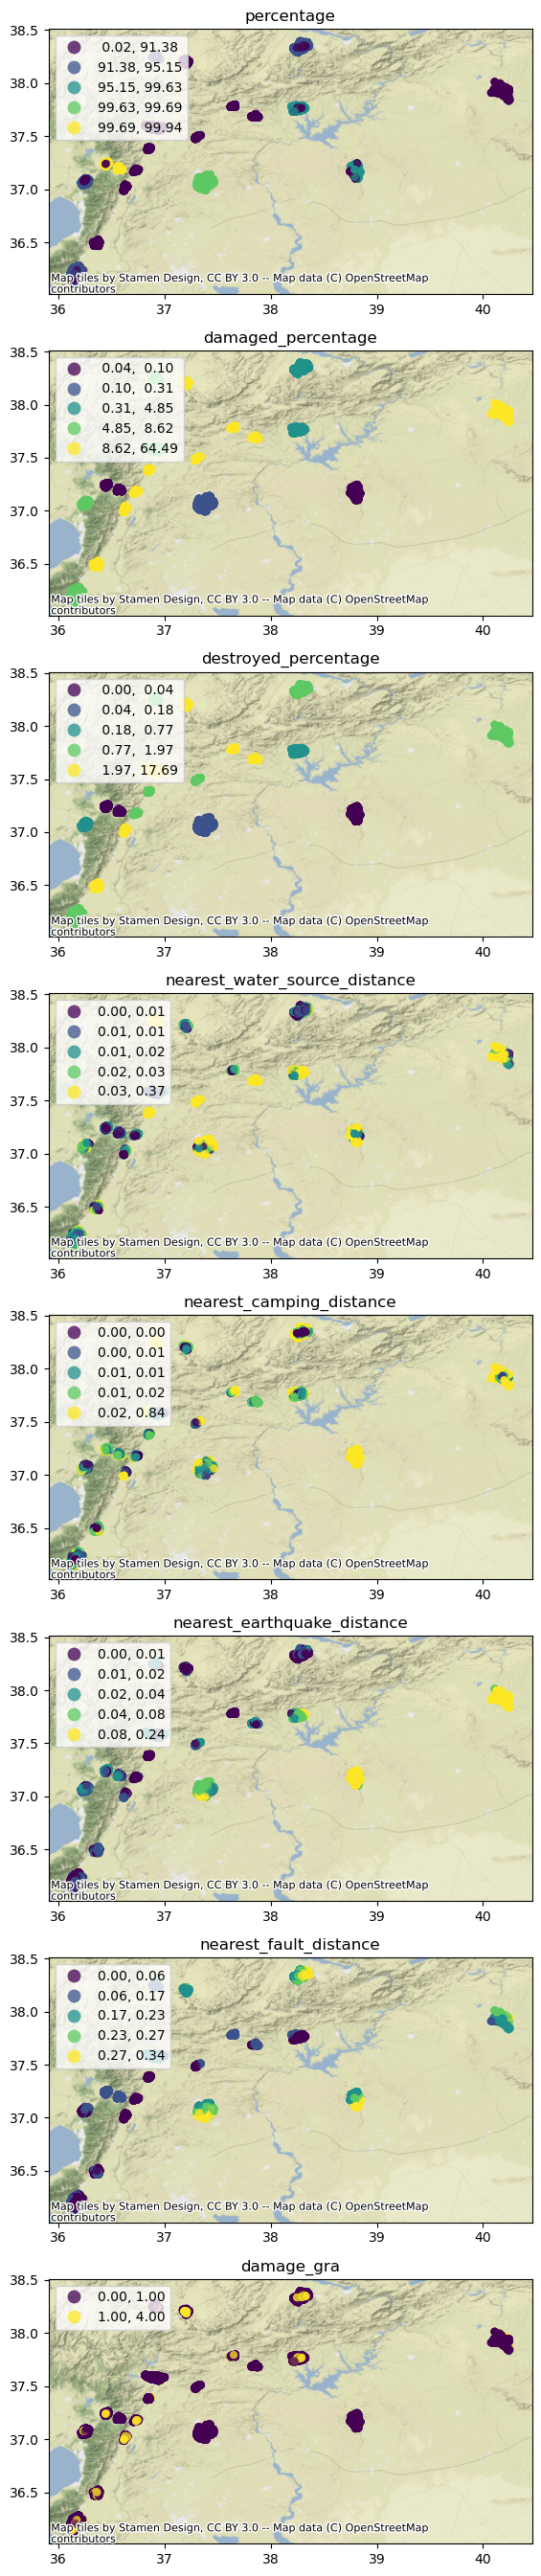

In [31]:
# Create a 3x1 grid of subplots (for three plots)
f, axes = plt.subplots(8, 1, figsize=(9, 27))  # Adjusted figsize for three plots



for ax, column in zip(axes, percentage_columns):
    data.plot(
        column=column,
        cmap="viridis",
        scheme="quantiles",
        k=5,
        edgecolor="white",
        linewidth=0.0,
        alpha=0.75,
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax,
    )
    
    ctx.add_basemap(
        ax,
        crs=data.crs,
        source=ctx.providers.Stamen.TerrainBackground,
    )
    
    
    ax.set_title(column)  # Setting title for each subplot

plt.tight_layout()  # Adjusts the plots so that they don't overlap
plt.show()


In [32]:

import libpysal as lps
from esda.moran import Moran

# Assuming 'data' is your GeoDataFrame
# Creating a contiguity-based weight (Queen style by default)
w = lps.weights.Queen.from_dataframe(data)
w.transform = 'r'  # Row-standardize the weights



results = []

for column in percentage_columns:
    y = data[column]
    moran = Moran(y, w)
    
    results.append({
        'Column': column,
        'Moran\'s I': moran.I,
        'Expected I': moran.EI,
        'p-value': moran.p_sim
    })

df_results = pd.DataFrame(results)


/home/lapita/anaconda3/envs/new_geo_env/lib/python3.9/site-packages/libpysal/cg/voronoi.py:173: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  region_df["geometry"] = [Polygon(vertices[region]) for region in regions]
/home/lapita/anaconda3/envs/new_geo_env/lib/python3.9/site-packages/libpysal/cg/voronoi.py:176: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame construc

In [33]:
data['spatial_lag'] = lps.weights.lag_spatial(w, data['damage_gra'])

In [34]:
data[data['damage_gra'] != data['spatial_lag']]


,obj_type,info,damage_gra,locality,population,income,total_sales,second_sales,water_access,elec_cons,...,nearest_water_source_distance,nearest_camping_distance,nearest_earthquake_distance,nearest_fault_distance,elev,geometry,percentage,damaged_percentage,destroyed_percentage,spatial_lag
0,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,0.077874,0.020232,0.097845,0.016935,660.0,POINT (38.31425 37.76887),96.441229,3.558771,0.767868,1.000000
2,12-Non-residential Buildings,1251-Industrial buildings,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,0.081336,0.023588,0.100527,0.014585,660.0,POINT (38.31801 37.76861),96.441229,3.558771,0.767868,1.000000
3,12-Non-residential Buildings,1251-Industrial buildings,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,0.081953,0.024196,0.101013,0.014241,660.0,POINT (38.31868 37.76857),96.441229,3.558771,0.767868,1.000000
4,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,0.076146,0.018542,0.096334,0.017826,660.0,POINT (38.31254 37.76851),96.441229,3.558771,0.767868,1.000000
5,11-Residential Buildings,997-Not Applicable,1,ADIYAMAN,316140,4092,40087,20574,0.98,2060,...,0.077879,0.020192,0.097663,0.016458,660.0,POINT (38.31443 37.76839),96.441229,3.558771,0.767868,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98785,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,0.190268,0.012678,0.002051,0.028275,500.0,POINT (36.86159 37.37530),89.278351,10.721649,1.855670,1.000000
98786,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,0.190371,0.012777,0.002011,0.028395,500.0,POINT (36.86163 37.37518),89.278351,10.721649,1.855670,1.000000
98790,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,0.194789,0.013011,0.000538,0.031945,500.0,POINT (36.85817 37.37151),89.278351,10.721649,1.855670,1.333333
98791,212-Railways,997-Not Applicable,1,Turkoglu,78976,5997,1938,536,0.95,4343,...,0.194226,0.012857,0.001146,0.031466,500.0,POINT (36.85859 37.37198),89.278351,10.721649,1.855670,1.375000


In [41]:

#data.drop(columns =['geometry'], inplace = True)
pandas_data = pd.DataFrame(data)

gdf = gpd.GeoDataFrame(pandas_data, geometry=gpd.points_from_xy(pandas_data.longitude, pandas_data.latitude))

pandas_data.to_csv('../data/processed/df.csv', index=False)
